# Fine-Tuned Tic-Tac-Toe Thinker: A Fully Computer Vision-Based Tic-Tac-Toe Solver

Here, we present the 5T: Fine-Tuned Tic-Tac-Toe Thinker, a tic-tac-toe solver fully implemented via computer vision, without a separate minimax or evaluation algorithm.

In [ ]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from torch.nn import Module, Sequential, Linear, Sigmoid, CrossEntropyLoss, Conv2d, MaxPool2d, ReLU, Dropout, Flatten, Softmax
from torch.optim import Adam
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#### some utility functions ####
# translate label into one of X win, O win, Tie
def translate_label(label):
  if label == 1:
    return "O win"
  elif label == 2:
    return "X win"
  else:
    return "Tie"

# plot validation loss
def plot_validation_loss(loss, title="Validation Loss"):
  plt.figure(figsize=(8, 6))
  plt.plot(loss)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Log Loss')
  plt.title(title)
  plt.show()

# use GPU if available
use_cuda = torch.cuda.is_available()

## Load in Generated Data

In [ ]:
data = torch.load("data.pt")

In [ ]:
# 80-10-10 train-test-validation split
train_set, test_val_set = random_split(data, [round(len(data)*0.8), len(data)-round(len(data)*0.8)])
val_set, test_set = random_split(test_val_set, [round(len(test_val_set)*0.5), len(test_val_set)-round(len(test_val_set)*0.5)])

In [ ]:
print(f"Training set: {len(train_set)}")
print(f"Test set: {len(test_set)}")
print(f"Validation set: {len(val_set)}")

Training set: 13147
Test set: 1643
Validation set: 1644


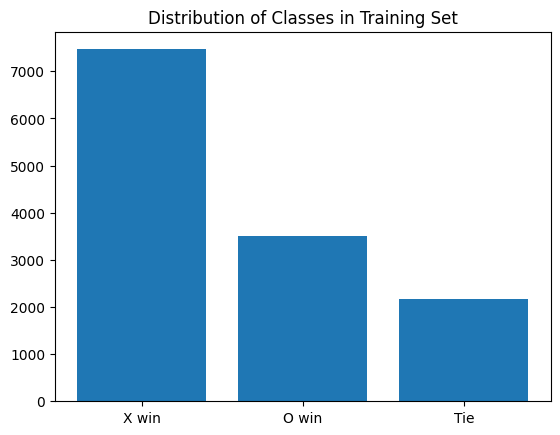

In [ ]:
# plot the distribution of labels in the training set
freqs = {'X win': 0, 'O win': 0, 'Tie': 0}

for _, label in train_set:
  if label == 0:
    freqs['Tie'] += 1
  elif label == 1:
    freqs['O win'] += 1
  else:
    freqs['X win'] += 1

plt.bar(freqs.keys(), freqs.values())
plt.title("Distribution of Classes in Training Set")
plt.show()

In [ ]:
# create data loaders for each of the train, test, and validation sets
train_loader = DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=32,
    shuffle=True
)

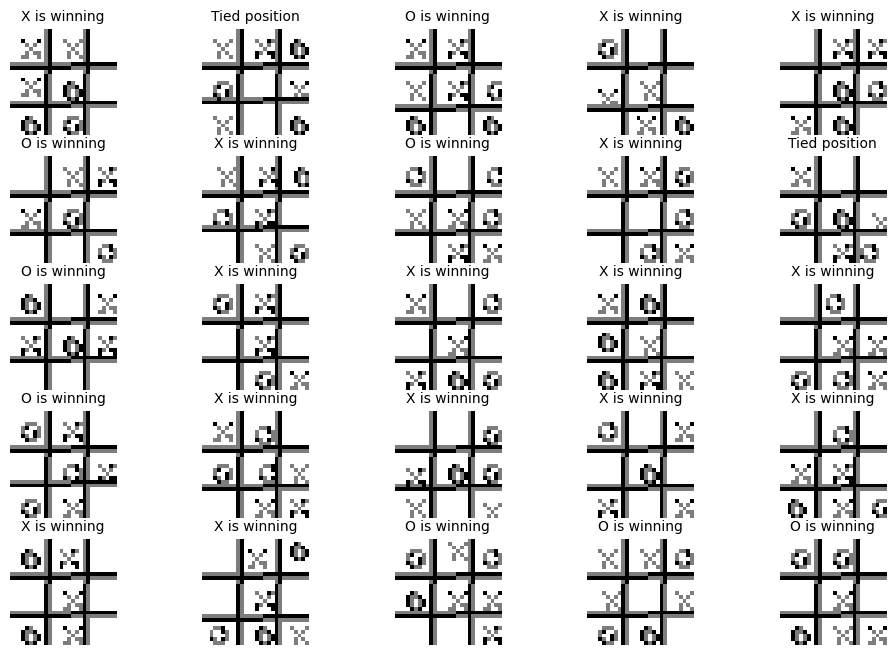

In [ ]:
# let's plot a couple of boards and their associated label
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 5, 5

for i in range(1, n_cols * n_rows + 1):
  rand_idx = torch.randint(len(train_set), size=(1,)).item()
  img, label = train_set[rand_idx]

  # determine who is winning from label
  title = None

  if label == 1:
    title = "O is winning"
  elif label == 2:
    title = "X is winning"
  else:
    title = "Tied position"

  # plot digit
  image = np.asarray(img).reshape((28, 28))
  fig.add_subplot(n_rows, n_cols, i)
  plt.title(title, fontdict = {'fontsize': 10})
  plt.axis("off")
  plt.imshow(image, cmap='gray')

plt.show()

## CNN From Scratch

### Model Architecture

In [ ]:
# for our CNN, we will use 3 convolutional layers, 2 fully connected hidden layers, and 1 output layer
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding='same')
    self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=1, padding=1)
    self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding='same')
    self.fc1 = Linear(6*6*128, 1024)
    self.fc2 = Linear(1024, 512)
    self.output = Linear(512, 3)

    self.relu = ReLU()
    self.pool = MaxPool2d(kernel_size=(2,2), stride=2)
    self.flatten = Flatten()
    self.dropout = Dropout(0.3)
    self.softmax = Softmax(dim=1)

    # initialize the weights according using kaiming uniform initialization
    torch.nn.init.kaiming_uniform_(self.conv1.weight)
    torch.nn.init.kaiming_uniform_(self.conv2.weight)
    torch.nn.init.kaiming_uniform_(self.conv3.weight)
    torch.nn.init.kaiming_uniform_(self.fc1.weight)
    torch.nn.init.kaiming_uniform_(self.fc2.weight)
    torch.nn.init.kaiming_uniform_(self.output.weight)

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv3(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.flatten(out)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.output(out)
    return self.softmax(out)

### Training

In [ ]:
# train model
cnn_model = CNN()

weights = torch.tensor([freqs['X win']/freqs['Tie'], freqs['X win']/freqs['O win'], 1.0])

if use_cuda: # use GPU if available
  cnn_model = cnn_model.cuda()
  weights = weights.cuda()

In [ ]:
loss_fn = CrossEntropyLoss(weight=weights) # use cross-entropy loss, weighted based on the proportion of each class in the training set
learning_rate = 1e-4
optimizer = Adam(cnn_model.parameters(), lr=learning_rate) # Adam for optimization

In [ ]:
n_epochs = 100

# keep track of validation loss over multiple epochs
overall_val_loss = []
cnn_best_loss = float('inf')

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = cnn_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validation accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = cnn_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # save best model so far (based on validation loss)
  if np.mean(val_loss) < cnn_best_loss:
    cnn_best_loss = np.mean(val_loss)

    # save best model
    torch.save(cnn_model.state_dict(), "./best_cnn_model")

  # early stopping: if validation loss increases in 5 consecutive epochs, stop training
  if len(overall_val_loss) >= 5 and overall_val_loss[-5:] == sorted(overall_val_loss[-5:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/100] Validation Loss: 1.2043385597375722, Validation Accuracy: 0.27684294890898925
[Epoch 2/100] Validation Loss: 1.0583718361762853, Validation Accuracy: 0.30428685906987923
[Epoch 3/100] Validation Loss: 1.0092019473130887, Validation Accuracy: 0.5024038461538461
[Epoch 4/100] Validation Loss: 1.0090638078176057, Validation Accuracy: 0.5030048076923077
[Epoch 5/100] Validation Loss: 1.0008956984831736, Validation Accuracy: 0.49439102640518773
[Epoch 6/100] Validation Loss: 0.9985620666008729, Validation Accuracy: 0.5012019230769231
[Epoch 7/100] Validation Loss: 0.9965859021131809, Validation Accuracy: 0.5336538461538461
[Epoch 8/100] Validation Loss: 0.9851054778465858, Validation Accuracy: 0.5490785264051877
[Epoch 9/100] Validation Loss: 0.9810528548864218, Validation Accuracy: 0.5010016033282647
[Epoch 10/100] Validation Loss: 0.968547407251138, Validation Accuracy: 0.5562900648667262
[Epoch 11/100] Validation Loss: 0.9435864079457063, Validation Accuracy: 0.574118590125

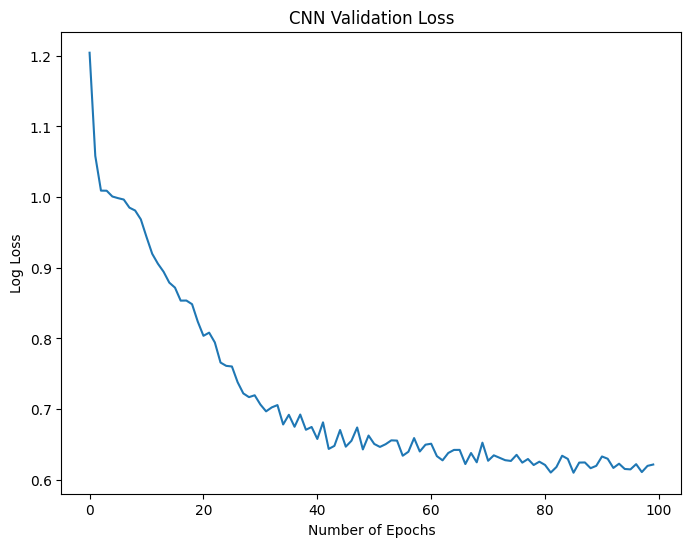

In [ ]:
plot_validation_loss(overall_val_loss, title="CNN Validation Loss")

In [ ]:
# load best model
best_cnn_model = CNN()

if use_cuda:
  best_cnn_model = best_cnn_model.cuda()

best_cnn_model.load_state_dict(torch.load("./best_cnn_model"))
best_cnn_model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=1)
)

### Testing

In [ ]:
# evaluate test accuracy
cnn_test_accuracy = []

# loop over the batches in test set
for idx, (x, labels) in enumerate(test_loader):
  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = best_cnn_model(x)

  # make predictions by taking the highest of the softmax outputs
  _, predictions = torch.max(out.data, 1)
  cnn_test_accuracy.append(((predictions == labels).sum() / len(labels)).item())

print(f"Test Accuracy: {np.mean(cnn_test_accuracy)}")

Test Accuracy: 0.9495738641573832


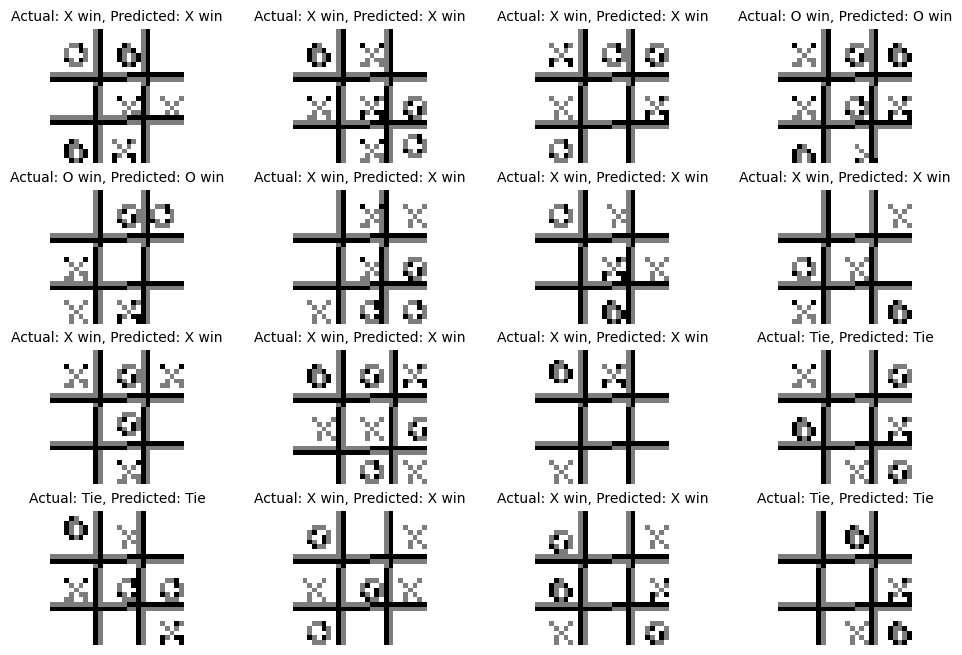

In [ ]:
# plot some sample correct predictions
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for img, label in test_set:
  if i > n_cols * n_rows:
    break

  x = torch.reshape(img, (1, 1, 28, 28))

  x = x.type(torch.FloatTensor)
  label = label.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    label = label.cuda()

  x = Variable(x)
  label = Variable(label)

  # forward propagation
  out = best_cnn_model(x)

  # make prediction
  _, prediction = torch.max(out.data, 1)

  # only plot if correct
  if prediction == label:
    image = np.asarray(img).reshape((28, 28))
    fig.add_subplot(n_rows, n_cols, i)
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    plt.title(f"Actual: {translate_label(label.item())}, Predicted: {translate_label(prediction.item())}",
              fontdict = {'fontsize': 10})

    i += 1

plt.show()

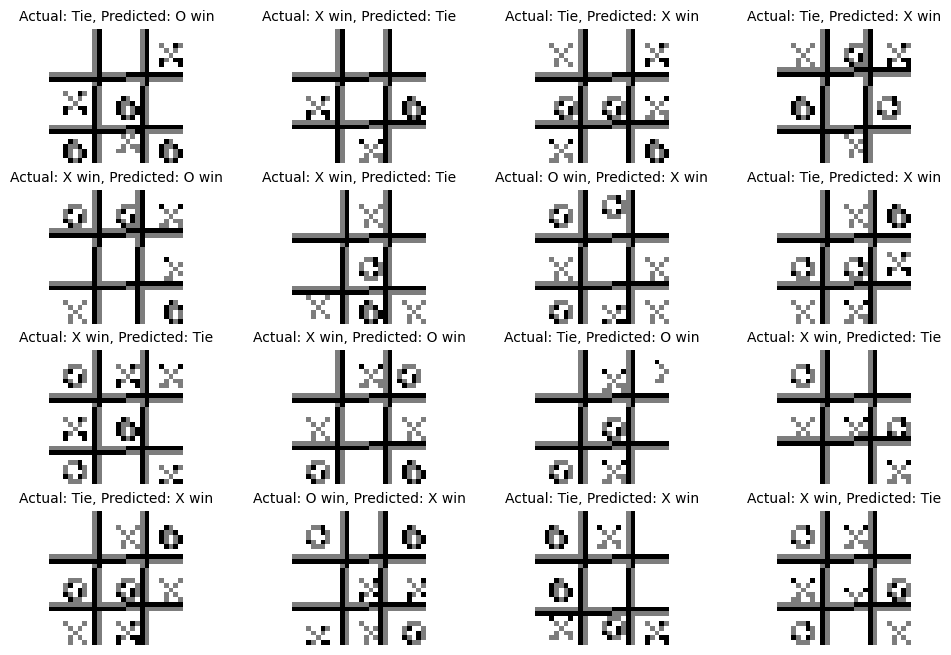

In [ ]:
# plot some sample mistakes
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for img, label in test_set:
  if i > n_cols * n_rows:
    break

  x = torch.reshape(img, (1, 1, 28, 28))

  x = x.type(torch.FloatTensor)
  label = label.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    label = label.cuda()

  x = Variable(x)
  label = Variable(label)

  # forward propagation
  out = best_cnn_model(x)

  # make prediction
  _, prediction = torch.max(out.data, 1)

  # only plot if mistake
  if prediction != label:
    image = np.asarray(img).reshape((28, 28))
    fig.add_subplot(n_rows, n_cols, i)
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    plt.title(f"Actual: {translate_label(label.item())}, Predicted: {translate_label(prediction.item())}",
              fontdict = {'fontsize': 10})

    i += 1

plt.show()

## Domain Transfer and Network Surgery

### ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT) # load in ResNet50 network architecture

In [ ]:
# freeze all current layers (except the last two that we will add)
for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
# replace last fully connected layer with a fully connected layer + softmax
resnet_model.fc = Sequential(OrderedDict([
    ('fc1', Linear(in_features=2048, out_features=3, bias=True)),
    ('softmax', Softmax(dim=1))
]))

In [ ]:
weights = torch.tensor([freqs['X win']/freqs['Tie'], freqs['X win']/freqs['O win'], 1.0])

if use_cuda: # use GPU if available
  resnet_model = resnet_model.cuda()
  weights = weights.cuda()

In [ ]:
loss_fn = CrossEntropyLoss(weight=weights) # use cross-entropy loss
learning_rate = 1e-3
optimizer = Adam(resnet_model.parameters(), lr=learning_rate) # Adam for optimization

In [ ]:
n_epochs = 50

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = resnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = resnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 3 consecutive epochs, stop training
  if len(overall_val_loss) >= 3 and overall_val_loss[-3:] == sorted(overall_val_loss[-3:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/50] Validation Loss: 1.0943272778621087, Validation Accuracy: 0.41065705166413236
[Epoch 2/50] Validation Loss: 1.085123740709745, Validation Accuracy: 0.3723958335243739
[Epoch 3/50] Validation Loss: 1.0833621758681078, Validation Accuracy: 0.4048477571744185
[Epoch 4/50] Validation Loss: 1.0840070625910392, Validation Accuracy: 0.37479967967822003
[Epoch 5/50] Validation Loss: 1.0810268567158625, Validation Accuracy: 0.3860176285872093
[Epoch 6/50] Validation Loss: 1.0803945362567902, Validation Accuracy: 0.37239583338109344
[Epoch 7/50] Validation Loss: 1.0886718390079646, Validation Accuracy: 0.35717147474105543
[Epoch 8/50] Validation Loss: 1.0929384919313283, Validation Accuracy: 0.3896233978179785
Training terminated early after 8 epochs


In [ ]:
# unfreeze all layers and continue training
for param in resnet_model.parameters():
    param.requires_grad = True

In [ ]:
# use a smaller learning rate
if use_cuda:
  resnet_model = resnet_model.cuda()
learning_rate = 1e-4
optimizer = Adam(resnet_model.parameters(), lr=learning_rate)

In [ ]:
n_epochs = 100

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = resnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = resnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 5 consecutive epochs, stop training
  if len(overall_val_loss) >= 5 and overall_val_loss[-5:] == sorted(overall_val_loss[-5:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/100] Validation Loss: 1.0908844299041307, Validation Accuracy: 0.3778044873705277
[Epoch 2/100] Validation Loss: 1.0584652366546483, Validation Accuracy: 0.39883814121668154
[Epoch 3/100] Validation Loss: 1.0446222378657415, Validation Accuracy: 0.45092147474105543
[Epoch 4/100] Validation Loss: 1.030512110545085, Validation Accuracy: 0.4629407052237254
[Epoch 5/100] Validation Loss: 1.0116951912641525, Validation Accuracy: 0.48177083409749544
[Epoch 6/100] Validation Loss: 1.007372381595465, Validation Accuracy: 0.4923878208949016
[Epoch 7/100] Validation Loss: 0.9942346822756988, Validation Accuracy: 0.5062099362795169
[Epoch 8/100] Validation Loss: 0.9853295477537009, Validation Accuracy: 0.5092147439718246
[Epoch 9/100] Validation Loss: 0.9782516956329346, Validation Accuracy: 0.5116185901256708
[Epoch 10/100] Validation Loss: 0.9619908447449024, Validation Accuracy: 0.5478766033282647
[Epoch 11/100] Validation Loss: 0.9577271560063729, Validation Accuracy: 0.5647035264051

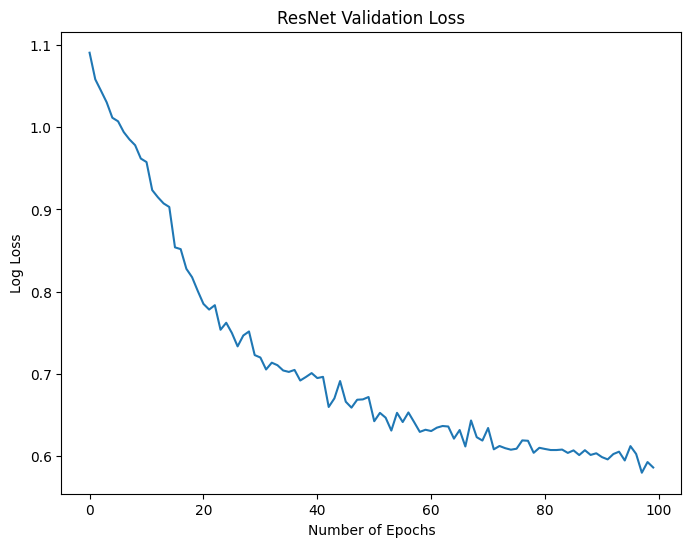

In [ ]:
plot_validation_loss(overall_val_loss, title="ResNet Validation Loss")

In [ ]:
# evaluate test accuracy
resnet_test_accuracy = []

# loop over the batches in test set
for idx, (x, labels) in enumerate(test_loader):
  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = resnet_model(x)

  # make predictions by taking the highest of the softmax outputs
  _, predictions = torch.max(out.data, 1)
  resnet_test_accuracy.append(((predictions == labels).sum() / len(labels)).item())

print(f"Test Accuracy: {np.mean(resnet_test_accuracy)}")

Test Accuracy: 0.9597902103112295


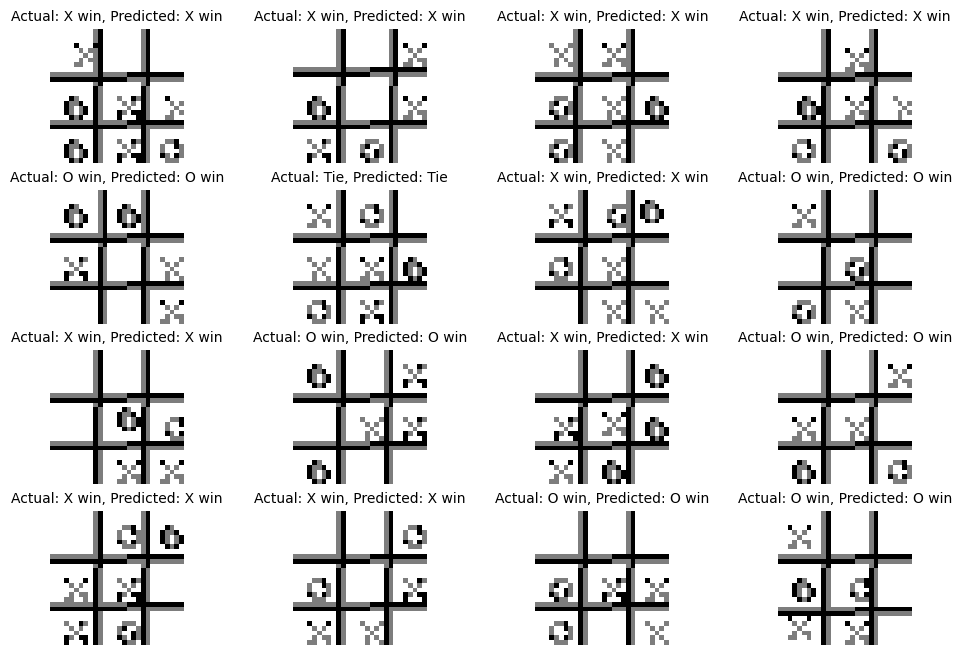

In [ ]:
# plot some sample correct predictions
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = resnet_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if correct
  for idx, prediction in enumerate(predictions):
    if prediction == labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()

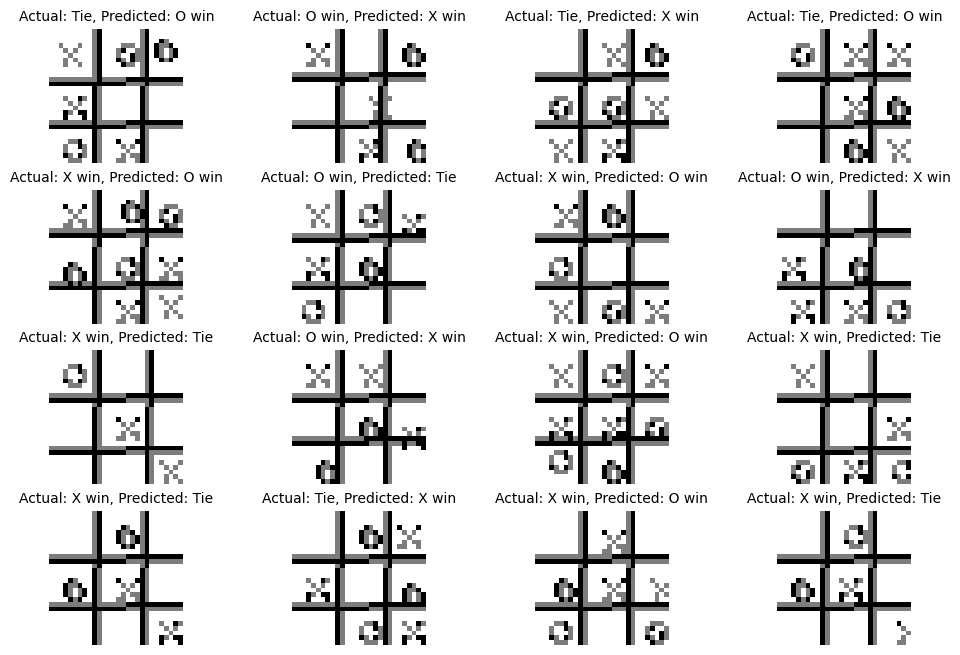

In [ ]:
# plot some sample mistakes
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = resnet_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if mistake
  for idx, prediction in enumerate(predictions):
    if prediction != labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()

### Vision Transformer (ViT_B_32)

In [ ]:
from torchvision.models import vit_b_32, ViT_B_32_Weights
from torch.nn.functional import interpolate

In [ ]:
vit_model = vit_b_32(weights=ViT_B_32_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:05<00:00, 63.7MB/s]


In [ ]:
# freeze all current layers (except the last two that we will add)
for param in vit_model.parameters():
    param.requires_grad = False

In [ ]:
# replace head with a fully connected layer + softmax
vit_model.heads = Sequential(OrderedDict([
    ('fc', Linear(in_features=768, out_features=3, bias=True)),
    ('softmax', Softmax(dim=1))
]))

In [ ]:
weights = torch.tensor([freqs['X win']/freqs['Tie'], freqs['X win']/freqs['O win'], 1.0])

if use_cuda: # use GPU if available
  vit_model = vit_model.cuda()
  weights = weights.cuda()

In [ ]:
loss_fn = CrossEntropyLoss(weight=weights) # use cross-entropy loss
learning_rate = 1e-3
optimizer = Adam(vit_model.parameters(), lr=learning_rate) # Adam for optimization

In [ ]:
n_epochs = 50

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
    x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = vit_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
    x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = vit_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 3 consecutive epochs, stop training
  if len(overall_val_loss) >= 3 and overall_val_loss[-3:] == sorted(overall_val_loss[-3:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/50] Validation Loss: 1.0206126112204332, Validation Accuracy: 0.44851762830064845
[Epoch 2/50] Validation Loss: 1.0217191794743905, Validation Accuracy: 0.4172676285872093
[Epoch 3/50] Validation Loss: 1.0203188818234663, Validation Accuracy: 0.46013621813975847
[Epoch 4/50] Validation Loss: 1.024072642509754, Validation Accuracy: 0.44471153846153844
[Epoch 5/50] Validation Loss: 1.017934961960866, Validation Accuracy: 0.4703525648667262
[Epoch 6/50] Validation Loss: 1.0137984385857215, Validation Accuracy: 0.5106169879436493
[Epoch 7/50] Validation Loss: 1.0461300817819743, Validation Accuracy: 0.5610977571744186
[Epoch 8/50] Validation Loss: 1.046733366755339, Validation Accuracy: 0.5510817307692307
Training terminated early after 8 epochs


In [ ]:
# unfreeze all layers and continue training
for param in vit_model.parameters():
    param.requires_grad = True

In [ ]:
# use a smaller learning rate
if use_cuda:
  vit_model = vit_model.cuda()
learning_rate = 1e-6
optimizer = Adam(vit_model.parameters(), lr=learning_rate)

In [ ]:
n_epochs = 100

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
    x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = vit_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
    x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = vit_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 5 consecutive epochs, stop training
  if len(overall_val_loss) >= 5 and overall_val_loss[-5:] == sorted(overall_val_loss[-5:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/100] Validation Loss: 1.2291607444102948, Validation Accuracy: 0.2564102564580165
[Epoch 2/100] Validation Loss: 1.2219618570346098, Validation Accuracy: 0.2604166670487477
[Epoch 3/100] Validation Loss: 1.2244930450732892, Validation Accuracy: 0.25841346153846156
[Epoch 4/100] Validation Loss: 1.2275020078970835, Validation Accuracy: 0.2564102564580165
[Epoch 5/100] Validation Loss: 1.2258384709174817, Validation Accuracy: 0.25841346153846156
[Epoch 6/100] Validation Loss: 1.228332363642179, Validation Accuracy: 0.25741185906987923
[Epoch 7/100] Validation Loss: 1.2223722969110196, Validation Accuracy: 0.2604166670487477
[Epoch 8/100] Validation Loss: 1.2193728387355804, Validation Accuracy: 0.2644230769230769
[Epoch 9/100] Validation Loss: 1.226367161824153, Validation Accuracy: 0.25841346153846156
[Epoch 10/100] Validation Loss: 1.229023399261328, Validation Accuracy: 0.25841346153846156
[Epoch 11/100] Validation Loss: 1.2271051383935487, Validation Accuracy: 0.260416667048

KeyboardInterrupt: ignored

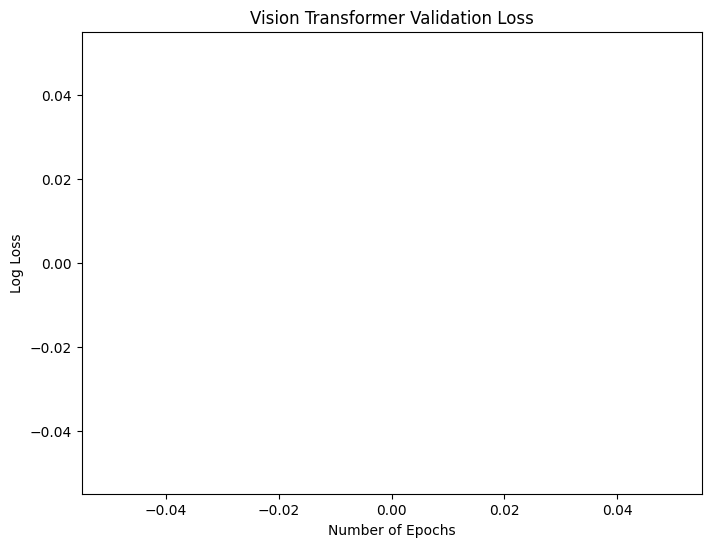

In [ ]:
plot_validation_loss(overall_val_loss, title="Vision Transformer Validation Loss")

In [ ]:
# evaluate test accuracy
vit_test_accuracy = []

# loop over the batches in test set
for idx, (x, labels) in enumerate(test_loader):
  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
  x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = vit_model(x)

  # make predictions by taking the highest of the softmax outputs
  _, predictions = torch.max(out.data, 1)
  vit_test_accuracy.append(((predictions == labels).sum() / len(labels)).item())

print(f"Test Accuracy: {np.mean(vit_test_accuracy)}")

Test Accuracy: 0.16985358412449175


In [ ]:
# plot some sample correct predictions
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
  x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = vit_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if correct
  for idx, prediction in enumerate(predictions):
    if prediction == labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()

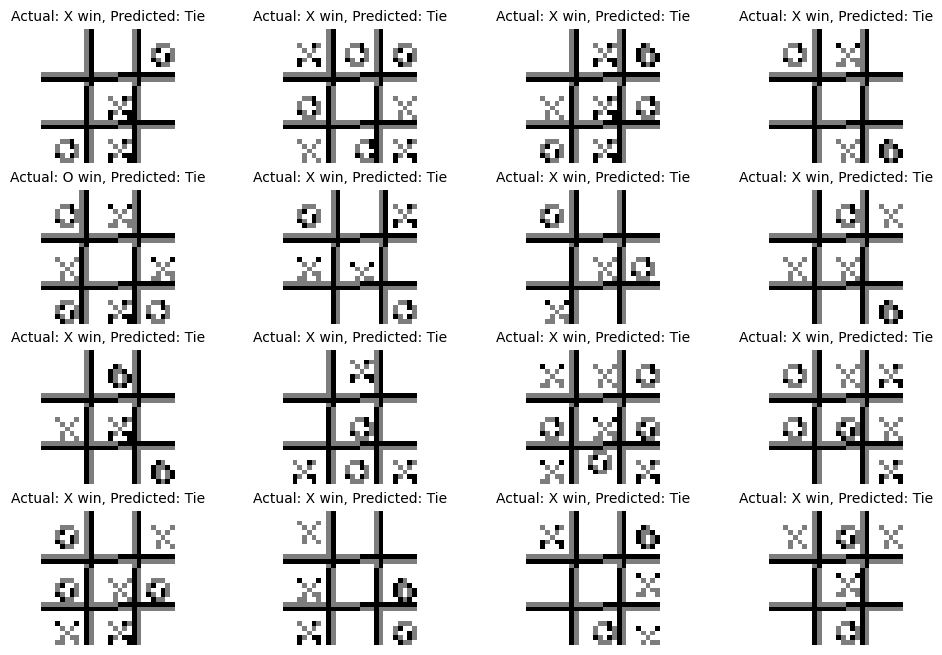

In [ ]:
# plot some sample correct predictions
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  # use interpolation to convert the input tensor to 224 x 224 (for use by the vision transformer)
  x = interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = vit_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if mistake
  for idx, prediction in enumerate(predictions):
    if prediction != labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()

### EfficientNetV2

In [ ]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

In [ ]:
efnet_model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:05<00:00, 41.7MB/s]


In [ ]:
# freeze all current layers (except the last two that we will add)
for param in efnet_model.parameters():
    param.requires_grad = False

In [ ]:
# replace classifier layer with a fully connected layer + softmax
efnet_model.classifier = Sequential(OrderedDict([
    ('fc', Linear(in_features=1280, out_features=3, bias=True)),
    ('softmax', Softmax(dim=1))
]))

In [ ]:
weights = torch.tensor([freqs['X win']/freqs['Tie'], freqs['X win']/freqs['O win'], 1.0])

if use_cuda: # use GPU if available
  efnet_model = efnet_model.cuda()
  weights = weights.cuda()

In [ ]:
loss_fn = CrossEntropyLoss(weight=weights) # use cross-entropy loss
learning_rate = 1e-3
optimizer = Adam(efnet_model.parameters(), lr=learning_rate) # Adam for optimization

In [ ]:
n_epochs = 50

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = efnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = efnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 3 consecutive epochs, stop training
  if len(overall_val_loss) >= 3 and overall_val_loss[-3:] == sorted(overall_val_loss[-3:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/50] Validation Loss: 1.1075183290701647, Validation Accuracy: 0.34214743627951694
[Epoch 2/50] Validation Loss: 1.1108099932853992, Validation Accuracy: 0.3425480769230769
[Epoch 3/50] Validation Loss: 1.1192868810433607, Validation Accuracy: 0.34775641044745076
Training terminated early after 3 epochs


In [ ]:
# unfreeze all layers and continue training
for param in efnet_model.parameters():
    param.requires_grad = True

In [ ]:
# use a smaller learning rate
if use_cuda:
  efnet_model = efnet_model.cuda()

learning_rate = 1e-4
optimizer = Adam(efnet_model.parameters(), lr=learning_rate)

In [ ]:
n_epochs = 100

# keep track of validation loss over multiple epochs
overall_val_loss = []

for epoch in range(n_epochs):
  # loop over the batches in train set
  for idx, (x, labels) in enumerate(train_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # zero out the gradients first to prevent accumulation of gradients on subsequent backwards passes
    optimizer.zero_grad()

    # forward propagation step on input features
    out = efnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    # backward step
    loss.backward() # compute gradients of model weights with respect to the loss
    optimizer.step() # update model weights using computed gradients

  # compute validation loss and validatcion accuracy
  val_loss = []
  val_accuracy = []

  # loop over the batches in val set
  for idx, (x, labels) in enumerate(val_loader):
    # convert x from 1 channel to 3 channels
    x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
    x = x.view(-1, 3, 28, 28)

    # wrap x and labels in Variable class for autograd support and use cuda for GPU
    x = x.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)

    if use_cuda:
      x = x.cuda()
      labels = labels.cuda()

    x = Variable(x)
    labels = Variable(labels)

    # forward propagation
    out = efnet_model(x)

    # calculate the cross-entropy loss
    loss = loss_fn(out, labels)

    val_loss.append(loss.item())

    # make predictions by taking the higher of the sigmoid outputs
    _, predictions = torch.max(out.data, 1)
    val_accuracy.append(((predictions == labels).sum() / len(labels)).item())

  print(f"[Epoch {epoch+1}/{n_epochs}] Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_accuracy)}")

  overall_val_loss.append(np.mean(val_loss))

  # early stopping: if validation loss increases in 5 consecutive epochs, stop training
  if len(overall_val_loss) >= 5 and overall_val_loss[-5:] == sorted(overall_val_loss[-5:]):
    print(f"Training terminated early after {epoch+1} epochs")
    break

[Epoch 1/100] Validation Loss: 1.0971535008687239, Validation Accuracy: 0.4032451923076923
[Epoch 2/100] Validation Loss: 1.0794448485741248, Validation Accuracy: 0.35697115384615385
[Epoch 3/100] Validation Loss: 1.079611518062078, Validation Accuracy: 0.39463141044745076
[Epoch 4/100] Validation Loss: 1.0605725921117342, Validation Accuracy: 0.42708333409749544
[Epoch 5/100] Validation Loss: 1.048733236698004, Validation Accuracy: 0.3996394230769231
[Epoch 6/100] Validation Loss: 1.0420276270462916, Validation Accuracy: 0.4342948719859123
[Epoch 7/100] Validation Loss: 1.0320682800733125, Validation Accuracy: 0.4405048076923077
[Epoch 8/100] Validation Loss: 1.0328188664638078, Validation Accuracy: 0.4557291670487477
[Epoch 9/100] Validation Loss: 1.0246022435335012, Validation Accuracy: 0.44090544890898925
[Epoch 10/100] Validation Loss: 1.0175410245473568, Validation Accuracy: 0.48778044948211086
[Epoch 11/100] Validation Loss: 1.0218236538080068, Validation Accuracy: 0.47576121871

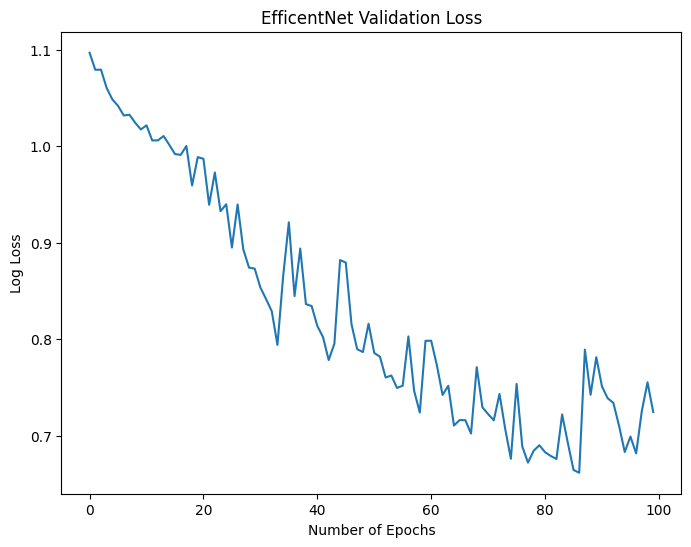

In [ ]:
plot_validation_loss(overall_val_loss, title="EfficentNet Validation Loss")

In [ ]:
# evaluate test accuracy
efnet_test_accuracy = []

# loop over the batches in test set
for idx, (x, labels) in enumerate(test_loader):
  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  # wrap x and labels in Variable class for autograd support and use cuda for GPU
  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = efnet_model(x)

  # make predictions by taking the highest of the softmax outputs
  _, predictions = torch.max(out.data, 1)
  efnet_test_accuracy.append(((predictions == labels).sum() / len(labels)).item())

print(f"Test Accuracy: {np.mean(efnet_test_accuracy)}")

Test Accuracy: 0.8149584795419986


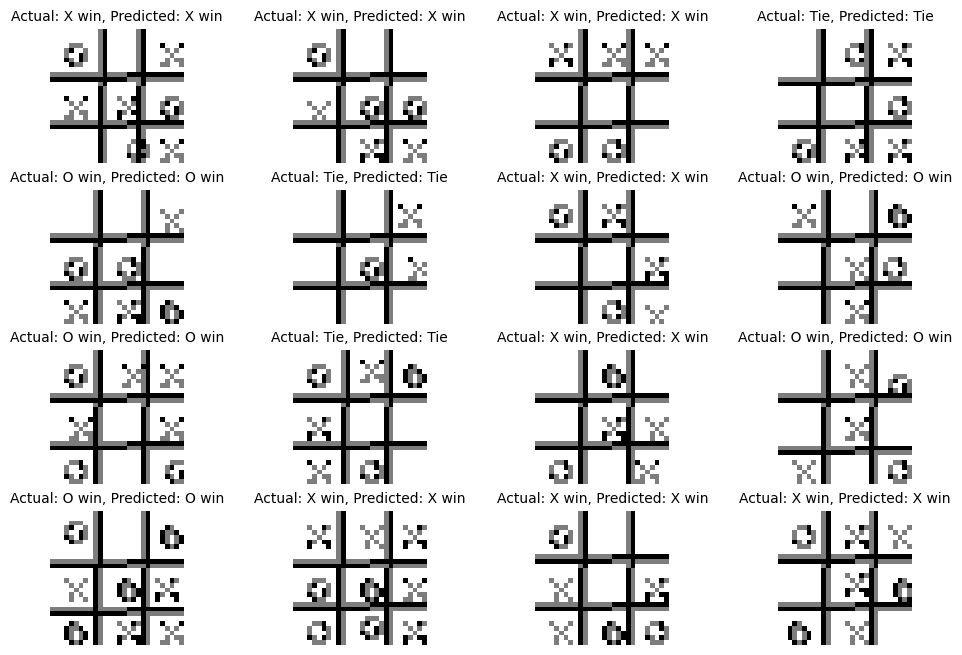

In [ ]:
# plot some sample correct predictions
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = efnet_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if correct
  for idx, prediction in enumerate(predictions):
    if prediction == labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()

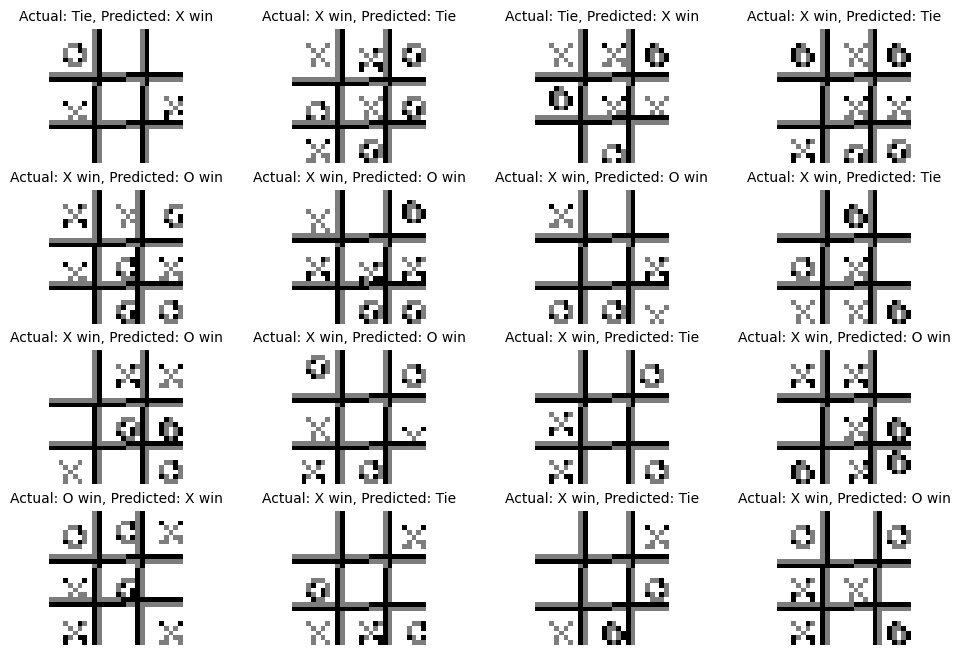

In [ ]:
# plot some sample mistakes
fig = plt.figure(figsize=(12,8))
n_cols, n_rows = 4, 4
i = 1

for idx, (x, labels) in enumerate(test_loader):
  if i > n_cols * n_rows:
    break

  origX = x

  # convert x from 1 channel to 3 channels
  x = x.unsqueeze(1).repeat(1, 1, 3, 1, 1)
  x = x.view(-1, 3, 28, 28)

  x = x.type(torch.FloatTensor)
  labels = labels.type(torch.LongTensor)

  if use_cuda:
    x = x.cuda()
    labels = labels.cuda()

  x = Variable(x)
  labels = Variable(labels)

  # forward propagation
  out = efnet_model(x)

  # make prediction
  _, predictions = torch.max(out.data, 1)

  # only plot if mistake
  for idx, prediction in enumerate(predictions):
    if prediction != labels[idx]:
      image = np.asarray(origX[idx]).reshape((28, 28))
      fig.add_subplot(n_rows, n_cols, i)
      plt.axis("off")
      plt.imshow(image, cmap='gray')

      plt.title(f"Actual: {translate_label(labels[idx].item())}, Predicted: {translate_label(prediction.item())}",
                fontdict = {'fontsize': 10})

      i += 1
      break

plt.show()